In [13]:
from pygsp.graphs import Graph
from scipy import sparse
from pygsp.graphs import Graph
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pyshtools
%matplotlib notebook

class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    sigmas = {4:0.5,
              8:0.3,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def __init__(self, bw=64):
       
        self.bw = bw

        ## sampling and coordinates calculation
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        # coords = coords[2*bw-1:]
        
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullSphereEquiangular, self).__init__(W=W, coords=coords)

<IPython.core.display.Javascript object>


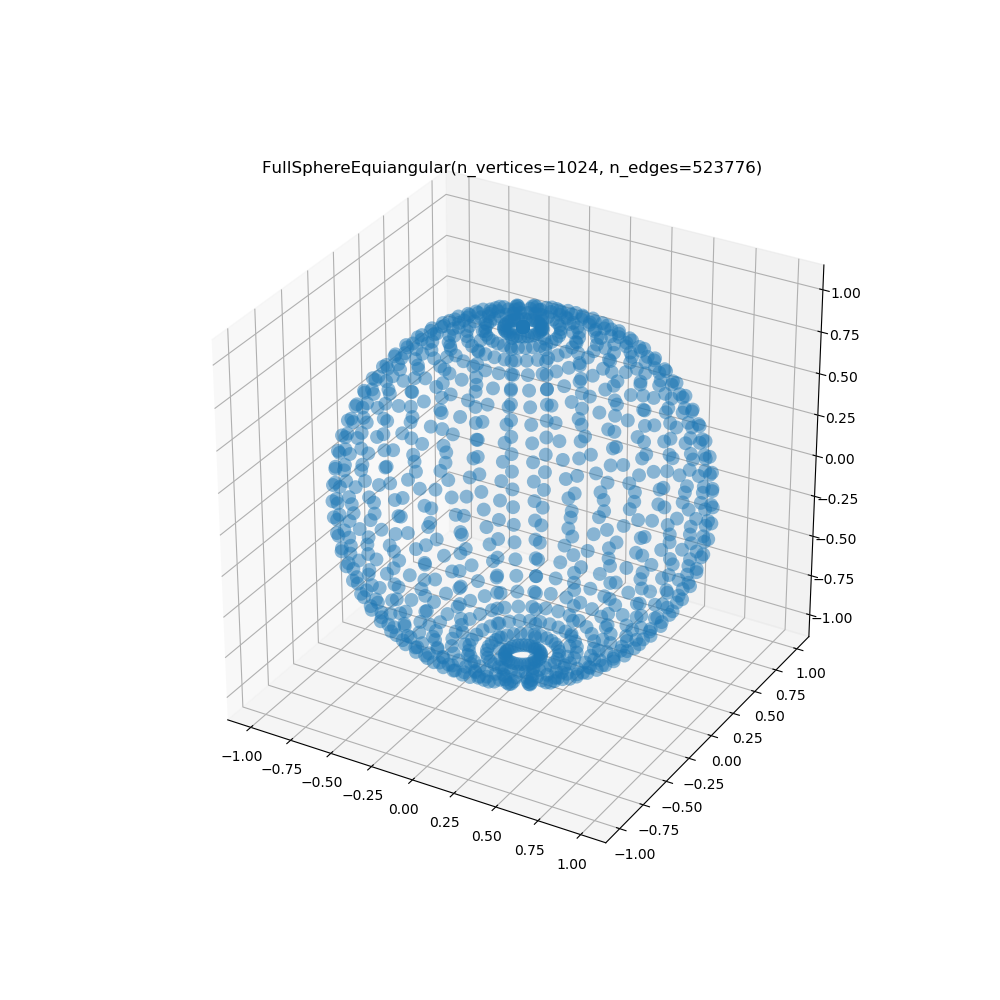

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
FullSphereEquiangular(16).plot()
plt.savefig('eqiuangular.png')

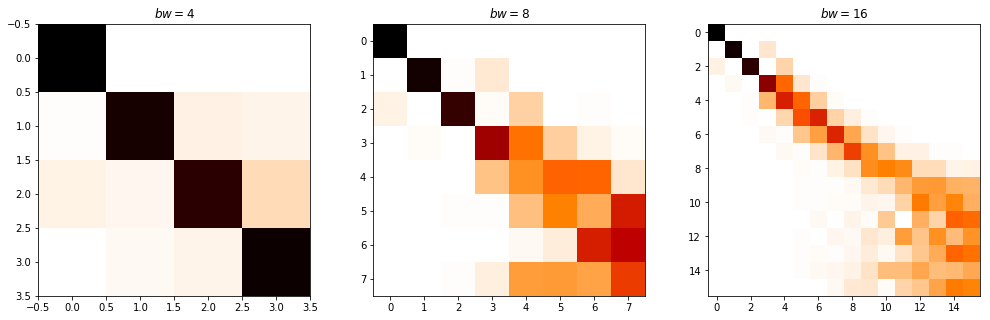

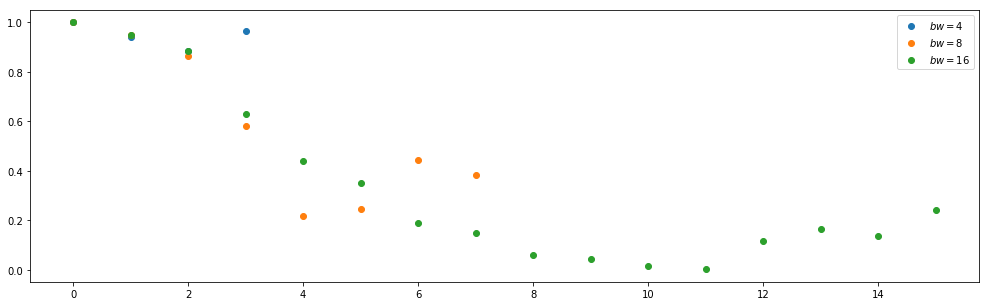

In [27]:
def to_array(f, bw):
    
    """From a 1-d vector to a 2D grid necessary to initiate a pyshtools.SHGrid object"""
    height, width = 2*bw, 2*bw
    array = np.zeros((height, width))  # shape=(longitude, latitude)
    # f = np.append([f[0]]*(2*bw-1), f)  # correct! the first line is the North pole repeated 2bw times
    
    # now we need to undo the meshgrid
    assert f.size == array.size
    for n, fx in enumerate(f):
        j = n%width
        i = n//width
        array[i, j] = fx
    return array


plt.rcParams['figure.figsize'] = (17, 5)

bws = [4, 8, 16]
graphs = []
spectral_content = dict()

for bw in bws:

    lmax = bw-1

    n_harmonics = np.cumsum(np.arange(1, 2*lmax+2, 2))[-1]
    graphs.append(FullSphereEquiangular(bw))
    graph = graphs[-1]

    graph.compute_fourier_basis(n_eigenvectors=n_harmonics)

    cl = np.empty((n_harmonics, lmax+1))
    for i in range(n_harmonics):
        eigenvector = graph.U[:, i]
        eig_array = to_array(eigenvector, bw)
        g = pyshtools.SHGrid.from_array(eig_array)
        clm = g.expand(normalization='unnorm')
        cl[i] = clm.spectrum()

    spectral_content[bw] = np.empty((lmax+1, lmax+1))
    start = 0
    for ell in range(lmax+1):
        end = start + (2 * ell + 1)
        spectral_content[bw][ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
        start = end

fig1, axes = plt.subplots(1, len(bws))
fig2, ax2 = plt.subplots()

for ax, (bw, sc) in zip(axes, spectral_content.items()):
    sc = sc / sc[0, 0]
    im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
    ax.set_title(rf'$bw={bw}$')
    energy_in = np.diag(sc)
    ax2.plot(energy_in, 'o', label=rf'$bw={bw}$')

ax2.legend();

fig1.savefig("equi_full.png")
fig2.savefig("equi_full_diagonal.png")

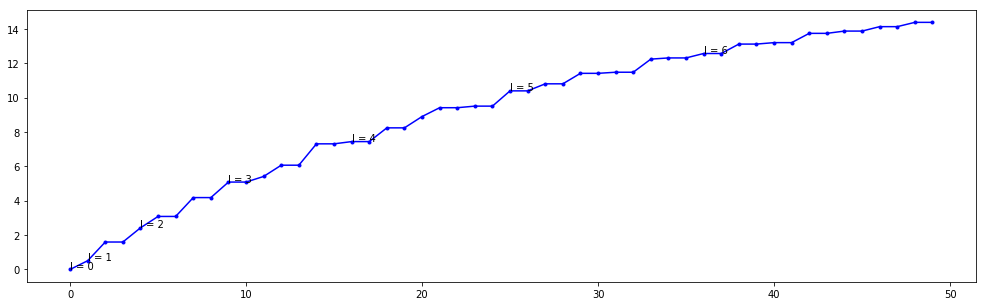

In [28]:
graph = graphs[-1]
plt.plot(graph.e[:50], 'b.')
plt.plot(graph.e[:50], 'b-')
for idx in range(7):
    plt.text(idx**2, graph.e[idx**2] + 0.006, 'l = {}'.format(idx));
plt.savefig('equi_full_eigenvalues_16')